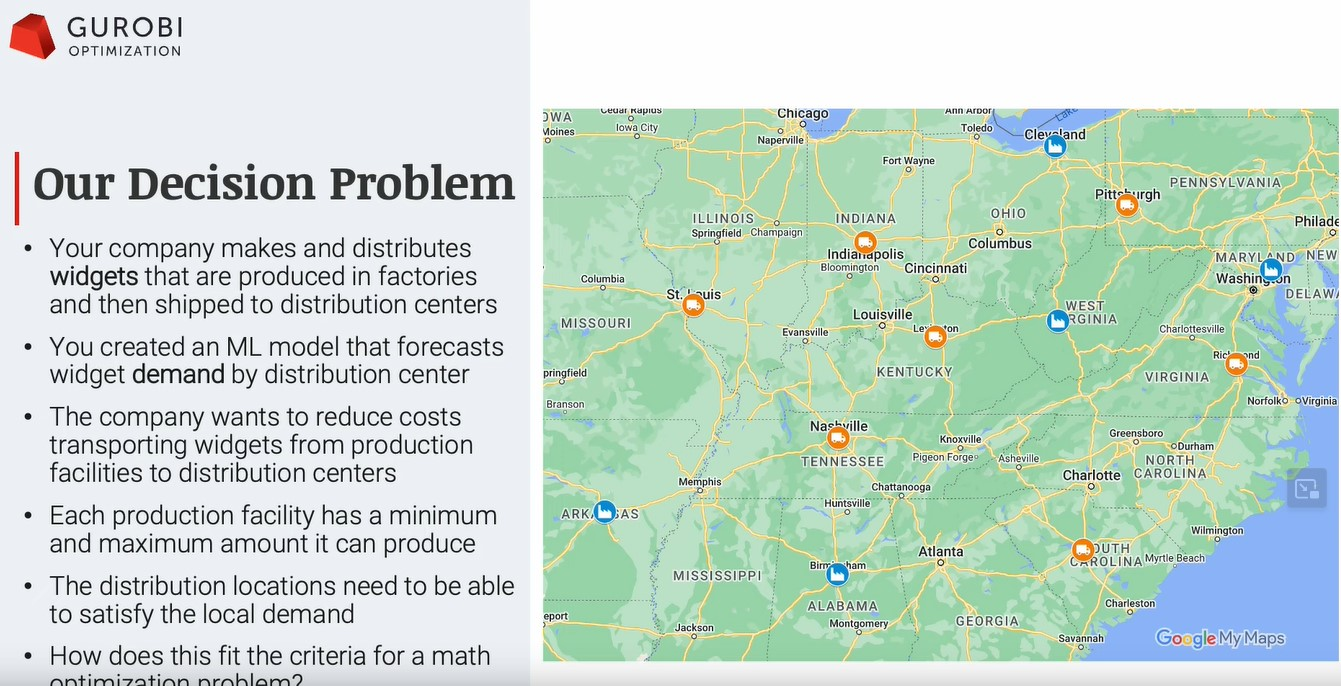

In [119]:
from IPython.display import Image
display(Image(filename='5_WorkForce_Prob.jpg'))

How many widgets each production facility should make and which distribution location it should supply  

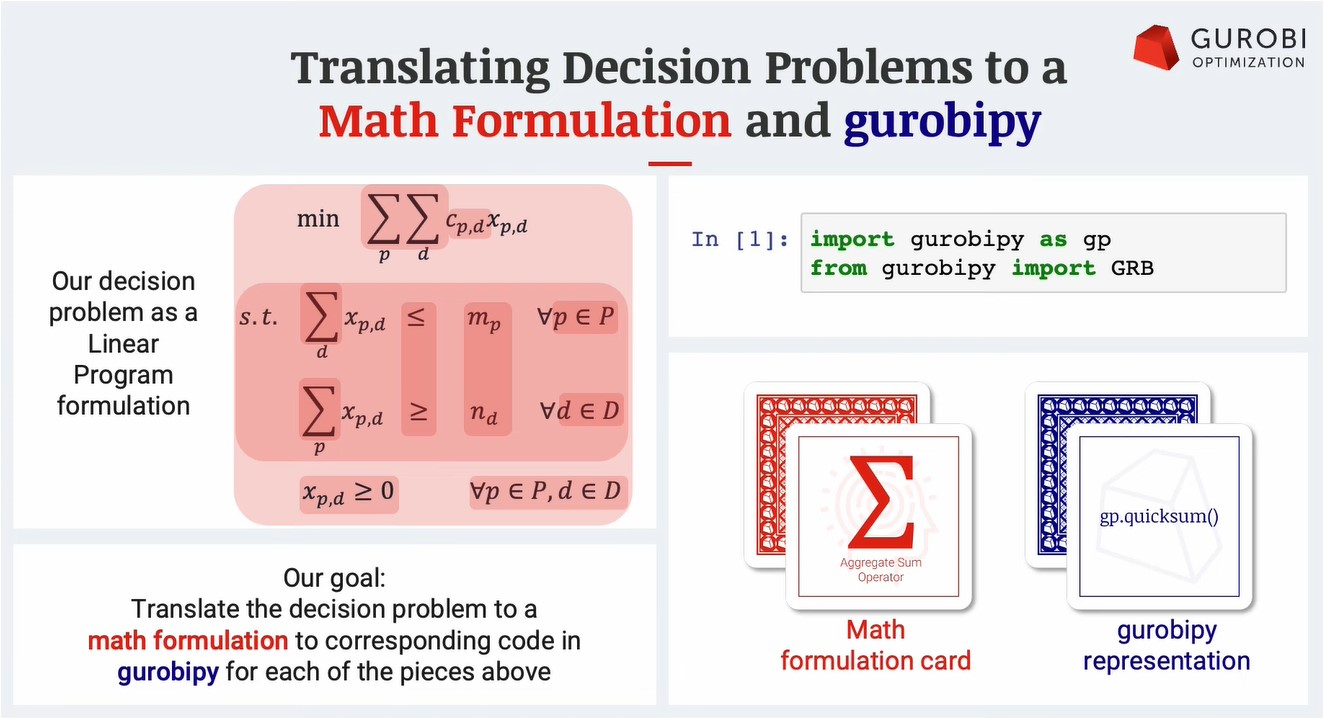

In [120]:
display(Image(filename='5_WorkForce_Formu.jpg'))

In [121]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

In [122]:
# Define sets for decision variables
production = ['Baltimore','Cleveland','Little Rock','Birmingham','Charleston']
distribution = ['Columbia','Indianapolis','Lexington','Nashville','Richmond','St. Louis']

In [123]:
# Define Model
opt_mod = gp.Model('widgets')

In [124]:
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/Modeling_Session_1/'

## Parameters

Parameters of a math optimization problem are values treated as constants in the model and are associated with the decision variables. For this decision problem these values are the limits of each production facility, the demand for each distribution center, and the pairwise costs between production and distribution locations. 

- $m_p$ is the max production in location $p$, $\forall p \in P \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\space\space \texttt{max}\_\texttt{prod[p]}$
- $n_d$ is the number of customers for a distribution center $d$, $\forall d \in D \quad\quad\quad\quad\quad\quad\quad\quad \texttt{n}\_\texttt{demand[d]}$
- $c_{p,d}$ is the cost to ship a widget between location $p$ and location $d$, $\forall p \in P, d \in D \quad\quad\quad \texttt{cost[p,d]}$

In [125]:
# Use .squeeze("columns") to make the costs a series
transport_cost_df = pd.read_csv(path + 'cost.csv', index_col=[0, 1])
transport_cost = transport_cost_df.squeeze()

In [126]:
# Pivot to view the costs a bit easier
transport_cost.reset_index().pivot(index='production', columns='distribution', values='cost')

distribution,Columbia,Indianapolis,Lexington,Nashville,Richmond,St. Louis
production,,,,,,
Baltimore,4.50,5.09,4.33,5.96,1.96,7.30
Birmingham,3.33,4.33,3.38,1.53,5.95,4.01
Charleston,3.02,2.61,1.61,4.44,2.36,4.60
Cleveland,2.43,2.37,2.54,4.13,3.20,4.88
Little Rock,6.42,4.83,3.39,4.40,7.44,2.92


In [127]:
max_prod = pd.Series([180, 200, 140, 80, 180], index=production, name='max_production')
n_demand = pd.Series([89, 95, 121, 101, 116, 181], index=distribution, name='demand')
max_prod.to_frame()
n_demand.to_frame()

,demand
Columbia,89
Indianapolis,95
Lexington,121
Nashville,101
Richmond,116
St. Louis,181


We also have the requirement that each production facility needs to produce at 75% of this maximum output. We'll denote this value by $a$ in the formulation "frac" for the fraction of maximum production required. Initially we set $a = 0.75$.
(Can also set unique production limit for each facility)

In [128]:
frac = 0.75

## Decision Variables
This is what the optimization solver determines, which are the actions you have control over. As a reminder, they come in three main flavors:
- `Continuous`: Price of a product
- `Integer`: The number of food trucks to use for an event
- `Binary`: Yes/no decision to include a certain stock in a portfolio

Decision variables (and parameters) are indexed using elements of sets that we define for the problem. In this example, let's start with a set of cities that produce our widget, which we call set $P$ for the formulation but can define as 'production' in the code. And a set of cities that distribute the widget $D$ and 'distribution' similarly. The decision here is to determine the number of boxes to send from each production facility to each distribution location. 

Let $x_{p,d}$ be the number of widgets that are produced at facility $i$ and shipped to location $j$.

### Add Variables in gurobipy
- [addVar()](https://www.gurobi.com/documentation/10.0/refman/py_model_addvar.html) adds a single variable
- [addVars()](https://www.gurobi.com/documentation/10.0/refman/py_model_addvar.html) adds a group of variables by sets/indices

When using `addVars` you have to provide the indices of the variables you want to add, which for us are the production and distribution locations. There are other arguments we can use and will cover a couple of them later on. 

### Decision Variables

In [151]:
# Loop through each p and d combination to create a decision variable
# m = gp.Model('widgets')
x = {}
for p in production:
    for d in distribution:
        x[p, d] = opt_mod.addVar(name=p+"_to_"+d)
opt_mod.update()
# x

In [130]:
# Provide each set for the indices 
# x = opt_mod.addVars(production, distribution, name = 'prod_ship')
# opt_mod.update()
# x

In [131]:
# The index of the tranporation costs have each combination of prodiction and distribution location
# x = opt_mod.addVars(transport_cost.index, name = 'prod_ship')
# opt_mod.update()
# x

The command `opt_mod.update()` updates the model to include any changes that have been made, like adding variables. It doesn't need to be run in every cell but if you see *Awaiting Model Update* in the output of a cell, then this should prevent that from happening.

## Constraints
We outlined production and demand constraints at the beginning of this example; now we formulate and code them. Note that it doesn't matter the order in which constraints (and/or decision variables) are added to the model.

### Add Constraints in gurobipy
Adding constraints to a model is similar to adding variables:
- [addConstr()](https://www.gurobi.com/documentation/10.0/refman/py_model_addconstr.html) adds a single constraint
- [addConstrs()](https://www.gurobi.com/documentation/10.0/refman/py_model_addconstrs.htmll) adds a group of constraints using a Python `generator` expression
 
### Our Constraints
To start, we'll formulate the demand constraints for each distribution location first and add them to the model.

\begin{align*} 
\sum_{p}x_{p,d} \ge n_d, \quad \forall d \in D \quad\quad \texttt{meet}\_\texttt{demand[d]}\\ 
\end{align*}

Add up all that is being produced at a production center and send it to the distribution center with quantity greater than or equal to the requirement of the distribution center.

This will be the first time we use [gp.quicksum()](https://www.gurobi.com/documentation/10.0/refman/py_quicksum.html). There are other ways to sum expressions in gurobipy and while this method isn't the most concise to code, it is easy to compare it to the summation in the formulation to see how it works. 

In [132]:
meet_demand = opt_mod.addConstrs((gp.quicksum(x[p,d] for p in production) >= n_demand[d] for d in distribution), name = 'meet_demand')
#meet_demand = opt_mod.addConstrs(x.sum('*', j) >= demand[j] for j in distribution)
opt_mod.update()
meet_demand

{'Columbia': <gurobi.Constr meet_demand[Columbia]>,
 'Indianapolis': <gurobi.Constr meet_demand[Indianapolis]>,
 'Lexington': <gurobi.Constr meet_demand[Lexington]>,
 'Nashville': <gurobi.Constr meet_demand[Nashville]>,
 'Richmond': <gurobi.Constr meet_demand[Richmond]>,
 'St. Louis': <gurobi.Constr meet_demand[St. Louis]>}

Next we have the maximum number of widgets each production facility can make. 
$$
\begin{align*} 
\sum_{d}x_{p,d} &\le m_p, &\forall p \in P \quad\quad &\texttt{can}\_\texttt{produce[p]}\\ 
\end{align*}
$$

In [133]:
can_produce = opt_mod.addConstrs((gp.quicksum(x[p,d] for d in distribution) <= max_prod[p] for p in production), name = 'can_produce')
opt_mod.update()
can_produce

{'Baltimore': <gurobi.Constr can_produce[Baltimore]>,
 'Cleveland': <gurobi.Constr can_produce[Cleveland]>,
 'Little Rock': <gurobi.Constr can_produce[Little Rock]>,
 'Birmingham': <gurobi.Constr can_produce[Birmingham]>,
 'Charleston': <gurobi.Constr can_produce[Charleston]>}

We also have that each facility must make at least 75% of its max production. 
$$
\begin{align*}
\sum_{d}x_{p,d} &\ge a*m_p,&\forall p \in P \quad\quad &\texttt{must}\_\texttt{produce[p]}\\ 
\end{align*}
$$

In [134]:
must_produce = opt_mod.addConstrs((gp.quicksum(x[p,d] for d in distribution) >= frac*max_prod[p] for p in production), name = 'must_produce')
opt_mod.update()
must_produce

{'Baltimore': <gurobi.Constr must_produce[Baltimore]>,
 'Cleveland': <gurobi.Constr must_produce[Cleveland]>,
 'Little Rock': <gurobi.Constr must_produce[Little Rock]>,
 'Birmingham': <gurobi.Constr must_produce[Birmingham]>,
 'Charleston': <gurobi.Constr must_produce[Charleston]>}

## Objective Function
We were told to **reduce** the transportation costs and we'll use this to determine our objective function as minimizing the total cost to ship widgets from production to distribution locations. 

### Setting the Objective in gurobipy
This is done using [setObjective()](https://www.gurobi.com/documentation/10.0/refman/py_model_setobjective.html). The second argument (in this case `GRB.MINIMIZE`) is called the model's *sense*. For a maximization problem we would use `GRB.MAXIMIZE`. 

### Our Objective Function
$$
\begin{align*} 
{\rm minimize} \space \sum_{p,d}c_{p,d}x_{p,d}, \quad \forall p \in P, d \in D\\ 
\end{align*}
$$

In [135]:
opt_mod.setObjective(gp.quicksum(transport_cost[i,j]*x[i,j] for i in production for j in distribution), GRB.MINIMIZE) 

## Find, Extract, and Analyze the Solution
Before running the optimization, it is a good idea to write an `lp` file. This is a text file that prints out the variables, constraints, and object like we would see in the *formulation*, just without the summation symbols and using the names we designated.

In [136]:
opt_mod.write('widget_shipment.lp')

In [137]:
opt_mod.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 16 rows, 30 columns and 90 nonzeros
Model fingerprint: 0x20186c14
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 2e+02]
Presolve removed 5 rows and 0 columns
Presolve time: 0.01s
Presolved: 11 rows, 35 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.610000e+02   0.000000e+00      0s
      15    1.7048900e+03   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.704890000e+03


$ 1704.89 is the optimal result

In [139]:
# opt_mod.getAttr('X', x)

In [142]:
x_values = pd.Series(opt_mod.getAttr('X', x), name = 'shipment', index = transport_cost.index)
sol = pd.concat([transport_cost, x_values], axis=1)
sol

cost  shipment
production  distribution                
Baltimore   Columbia      4.50       0.0
            Indianapolis  5.09       0.0
            Lexington     4.33       0.0
            Nashville     5.96      19.0
            Richmond      1.96     116.0
            St. Louis     7.30       0.0
Cleveland   Columbia      2.43      89.0
            Indianapolis  2.37      95.0
            Lexington     2.54       0.0
            Nashville     4.13       2.0
            Richmond      3.20       0.0
            St. Louis     4.88       0.0
Little Rock Columbia      6.42       0.0
            Indianapolis  4.83       0.0
            Lexington     3.39       0.0
            Nashville     4.40       0.0
            Richmond      7.44       0.0
            St. Louis     2.92     140.0
Birmingham  Columbia      3.33       0.0
            Indianapolis  4.33       0.0
            Lexington     3.38       0.0
            Nashville     1.53      80.0
            Richmond      5.95       0.0
            St. Louis     4.01       0.0
Charleston  Columbia      3.02       0.0
            Indianapolis  2.61       0.0
            Lexington     1.61     121.0
            Nashville     4.44       0.0
            Richmond      2.36       0.0
            St. Louis     4.60      41.0

In [143]:
sol[sol.shipment > 0]

cost  shipment
production  distribution                
Baltimore   Nashville     5.96      19.0
            Richmond      1.96     116.0
Cleveland   Columbia      2.43      89.0
            Indianapolis  2.37      95.0
            Nashville     4.13       2.0
Little Rock St. Louis     2.92     140.0
Birmingham  Nashville     1.53      80.0
Charleston  Lexington     1.61     121.0
            St. Louis     4.60      41.0

Other ways to get the solution

In [145]:
# all_vars = {v.varname: v.x for v in opt_mod.getVars()}
# all_vars

In [146]:
# Iterating over dictionary 
xvals = {k: v.x for k, v in x.items() if v.x > 0} 
xvals 

{('Baltimore', 'Nashville'): 19.0,
 ('Baltimore', 'Richmond'): 116.0,
 ('Cleveland', 'Columbia'): 89.0,
 ('Cleveland', 'Indianapolis'): 95.0,
 ('Cleveland', 'Nashville'): 2.0,
 ('Little Rock', 'St. Louis'): 140.0,
 ('Birmingham', 'Nashville'): 80.0,
 ('Charleston', 'Lexington'): 121.0,
 ('Charleston', 'St. Louis'): 41.0}

In [147]:
x_values.sum(), n_demand.sum()

(703.0, 703)

### Solution Analysis
While determining the optimal transportation of widgets was our goal, we may want to dig a little deeper into the solution. For example we can aggregate the total production by facility to see which locations (if any) did not produce their maximum capacity of widgets and which (if any) production facilities are at the lower bound of their production. 

In [148]:
# Sum the shipment amount by production facility
ship_out = sol.groupby('production')['shipment'].sum()
pd.DataFrame({'Remaining':max_prod - ship_out, 'Utilization':ship_out/max_prod})

,Remaining,Utilization
Baltimore,45.0,0.75
Birmingham,0.0,1.00
Charleston,18.0,0.90
Cleveland,14.0,0.93
Little Rock,0.0,1.00


In mathematical optimization, when the left-hand and right-hand sides of an inequality constraint are equal, we say the constraint is `binding`. When this *doesn't happen* then there is `slack` or `surplus` in that constraint. We can get this value by calling the `Slack` attribute of a constraint.

In [149]:
pd.DataFrame({'Remaining':[can_produce[p].Slack for p in production], 
              'Utilization':[1-can_produce[p].Slack/max_prod[p] for p in production]}, 
             index = production)

,Remaining,Utilization
Baltimore,45.0,0.75
Cleveland,14.0,0.93
Little Rock,0.0,1.00
Birmingham,0.0,1.00
Charleston,18.0,0.90


https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/optimization101/Modeling_Session_1/completed_modeling1.ipynb#scrollTo=bde35449-0b63-4bb4-9926-d20013b1b95b

https://www.youtube.com/watch?v=ES2z8O98kKY&list=PLHiHZENG6W8B_65-Unq-G59PtQtEc1Xj4&index=3